# nisotropic orientation optimization

In [1]:
import matplotlib.pyplot as plt
import meshzoo
import torch
from tqdm import tqdm

from torchfem import Shell
from torchfem.materials import OrthotropicPlaneStress

In [2]:
G_t = 10000 / (2.0 * (1 + 0.3))
mat = OrthotropicPlaneStress(
    E_1=100000, E_2=10000, nu_12=0.1, G_12=5000, G_13=G_t, G_23=G_t
)


# Rotation tensor
def R(phi):
    cos = torch.cos(phi)
    cos2 = cos**2
    sin = torch.sin(phi)
    sin2 = sin**2
    sincos = sin * cos
    return torch.stack(
        [
            torch.stack([cos2, sin2, 2 * sincos]),
            torch.stack([sin2, cos2, -2 * sincos]),
            torch.stack([-sincos, sincos, cos2 - sin2]),
        ],
    )

In [3]:
# Parameters
L = 100.0
F = -10.0
t = 1.0
Zm = 100.0

# Define plate
X = torch.linspace(0.0, 0.5 * L, 9)
Y = torch.linspace(0.0, 0.5 * L, 9)
points, cells = meshzoo.rectangle_tri(X, Y, variant="zigzag")
N = len(points)
Z = torch.zeros((N, 1), dtype=torch.float32)
nodes = torch.hstack([torch.tensor(points, dtype=torch.float32), Z])
elements = cells.tolist()

# Boundaries
bottom = nodes[:, 1] < 0.01
left = nodes[:, 0] < 0.01

# Boundary conditions
forces = torch.zeros((N, 6))
forces[0, 2] = F
displacements = torch.zeros((N, 6))
constraints = torch.zeros((N, 6), dtype=bool)
constraints[-1] = True
constraints[left, 0] = True
constraints[left, 4] = True
constraints[left, 5] = True
constraints[bottom, 1] = True
constraints[bottom, 3] = True
constraints[bottom, 5] = True

# Thickness
thickness = t * torch.ones(len(elements))

# Create Shell model
plate = Shell(
    nodes, elements, forces, displacements, constraints, thickness, mat.C(), mat.Cs()
)

# Solve
u, f = plate.solve()
mises = plate.compute_stress(u, z=0.25, mises=True)
plate.plot(
    u[:, 0:3],
    node_property={"u": torch.linalg.norm(u[:, 0:3], dim=1)},
    mirror=[True, True, False],
)

Widget(value="<iframe src='http://localhost:55161/index.html?ui=P_0x2b7033eb0_0&reconnect=auto' style='width: …

# Optimization

## Target function is the strain energy

In [4]:
def target_function(phi):
    # Recompute stiffnesses due to changed orientations
    plate.C = torch.einsum("ij...,jk,lk...->...il", R(phi), mat.C(), R(phi))
    plate.Cs = torch.einsum(
        "ij...,jk,lk...->...il", R(phi)[0:2, 0:2], mat.Cs(), R(phi)[0:2, 0:2]
    )
    # Solve
    u, f = plate.solve()
    # Return compliance
    return torch.inner(u.ravel(), f.ravel())

## The optimization

In [5]:
phi = torch.zeros((len(plate.elements)), requires_grad=True)

optimizer = torch.optim.Adam([phi], lr=0.1)

energies = []

for _ in tqdm(range(100)):
    optimizer.zero_grad()
    objective = target_function(phi)
    energies.append(objective.detach().item())
    objective.backward()
    optimizer.step()

100%|██████████| 100/100 [00:01<00:00, 69.20it/s]


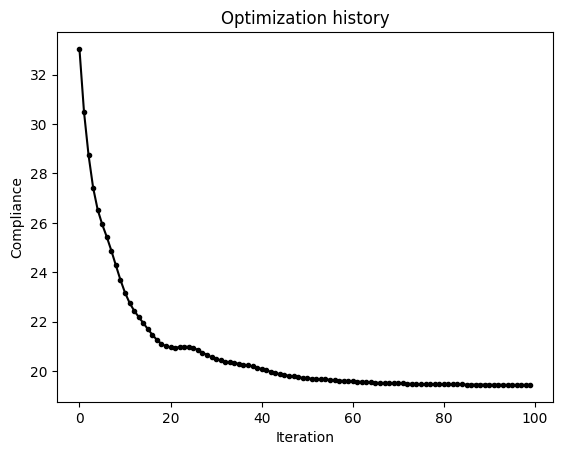

In [6]:
plt.plot(energies, ".-k")
plt.title("Optimization history")
plt.xlabel("Iteration")
plt.ylabel("Compliance")
plt.show()

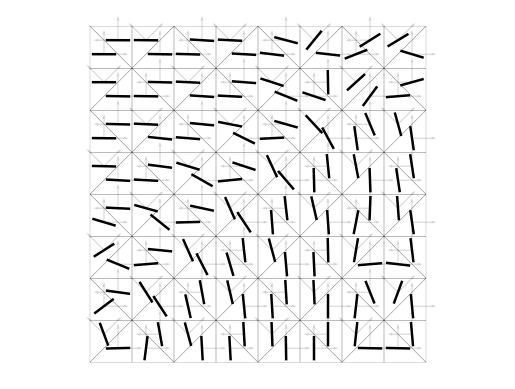

In [7]:
from matplotlib.collections import PolyCollection

# Compute optimized displacements
u, f = plate.solve()

# Compute properties
pos = plate.nodes
centers = pos[plate.elements, :].mean(dim=1)
loc_sys = plate.t
loc_dir = torch.stack([torch.cos(phi), -torch.sin(phi), torch.zeros_like(phi)]).T
dir = torch.einsum("...ij, ...j", plate.t.transpose(1, 2), loc_dir)

with torch.no_grad():
    # Plot local coordinate systems
    plt.quiver(
        centers[:, 0],
        centers[:, 1],
        loc_sys[:, 0, 0],
        loc_sys[:, 0, 1],
        width=0.002,
        color="lightgray",
    )
    plt.quiver(
        centers[:, 0],
        centers[:, 1],
        loc_sys[:, 1, 0],
        loc_sys[:, 1, 1],
        width=0.002,
        color="lightgray",
    )
    # Plot orientations
    plt.quiver(
        centers[:, 0],
        centers[:, 1],
        dir[:, 0],
        dir[:, 1],
        pivot="middle",
        headlength=0,
        headaxislength=0,
        headwidth=0,
        width=0.005,
        color="black",
    )
    # Plot elements
    pos = plate.nodes[:, 0:2]
    for element in plate.elements:
        x1 = [pos[node, 0] for node in element] + [pos[element[0], 0]]
        x2 = [pos[node, 1] for node in element] + [pos[element[0], 1]]
        plt.plot(x1, x2, color="black", linewidth=0.1)
    plt.axis("equal")
    plt.axis("off")
    plt.show()